# Similarity analysis

We want to determine if the different batch simulated data is able to capture the biological signal that is present in the original data:  How much of the real input data is captured in the simulated batch data?

In other words, we want to compare the representation of the real input data and the simulated batch data.  We will use **SVCCA** to compare these two representations.

Here, we apply Singular Vector Canonical Correlation Analysis [Raghu et al. 2017](https://arxiv.org/pdf/1706.05806.pdf) [(github)](https://github.com/google/svcca) to the UMAP and PCA representations of our batch 1 simulated dataset vs batch n simulated datasets.  The output of the SVCCA analysis is the SVCCA mean similarity score. This single number can be interpreted as a measure of similarity between our original data vs batched dataset.

Briefly, SVCCA uses Singular Value Decomposition (SVD) to extract the components explaining 99% of the variation. This is done to remove potential dimensions described by noise. Next, SVCCA performs a Canonical Correlation Analysis (CCA) on the SVD matrices to identify maximum correlations of linear combinations of both input matrices. The algorithm will identify the canonical correlations of highest magnitude across and within algorithms of the same dimensionality.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import random
import glob
import umap
import pickle
import warnings
warnings.filterwarnings(action='once')

from ggplot import *
from functions import cca_core
from sklearn.decomposition import PCA
from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Parameters
analysis_name = 'experiment_0'
NN_architecture = 'NN_2500_30'
num_PCs = 100
num_batches = [1,2,5,10,20,50,100,500,1000,2000,3000,6000]
#num_batches = [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]
#num_batches = [1,2,3,4,5,6,7,8,9,10,15,20,50,100,500,800,1000]

In [3]:
# Load data
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../.."))

simulated_data_file = os.path.join(
    base_dir,
    "data",
    "simulated",
    analysis_name,
    "simulated_data.txt")

batch_dir = os.path.join(
    base_dir,
    "data",
    "batch_simulated",
    analysis_name)

umap_model_file = umap_model_file = os.path.join(
    base_dir,
    "models",  
    NN_architecture,
    "umap_model.pkl")

In [4]:
# Read in UMAP model
infile = open(umap_model_file, 'rb')
umap_model = pickle.load(infile)
infile.close()

In [5]:
# Read in data
simulated_data = pd.read_table(
    simulated_data_file,
    header=0, 
    index_col=0,
    sep='\t')

simulated_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,5539,5540,5541,5542,5543,5544,5545,5546,5547,5548
0,0.690384,0.642501,0.454786,0.650650,0.374857,0.414020,0.353704,0.566726,0.447497,0.165201,...,0.375559,0.600063,0.562897,0.640035,0.661894,0.325466,0.576836,0.567330,0.708088,0.615353
1,0.691060,0.655274,0.527149,0.680636,0.371842,0.443242,0.374220,0.533293,0.502785,0.165815,...,0.290522,0.591411,0.609883,0.585498,0.596831,0.162511,0.459705,0.531669,0.710235,0.698571
2,0.826005,0.694632,0.510346,0.642764,0.611429,0.517733,0.344205,0.631357,0.663116,0.199852,...,0.589395,0.581802,0.596350,0.671666,0.753091,0.160510,0.521740,0.511157,0.747738,0.728167
3,0.600721,0.564944,0.417176,0.594936,0.382868,0.440063,0.387032,0.466111,0.402363,0.223858,...,0.345520,0.547836,0.470917,0.460431,0.564647,0.256127,0.509963,0.348220,0.579351,0.583487
4,0.621544,0.615939,0.473489,0.599652,0.401605,0.481008,0.364476,0.444714,0.447605,0.215759,...,0.450535,0.532127,0.588728,0.547413,0.578212,0.234255,0.424777,0.501985,0.704726,0.717408
5,0.735929,0.732768,0.545550,0.632979,0.460602,0.437013,0.325476,0.572898,0.682289,0.203184,...,0.414369,0.576000,0.692773,0.643043,0.746655,0.215016,0.509911,0.638528,0.775373,0.746010
6,0.643262,0.647871,0.449706,0.552101,0.407846,0.421758,0.371682,0.551611,0.530684,0.185147,...,0.392800,0.503936,0.558234,0.505509,0.600357,0.213806,0.478426,0.443200,0.641380,0.686138
7,0.517200,0.567826,0.363922,0.483920,0.346046,0.440530,0.442479,0.474701,0.372429,0.156235,...,0.368144,0.488229,0.461496,0.446372,0.480050,0.364032,0.477898,0.388174,0.528046,0.492165
8,0.746649,0.745975,0.622174,0.748726,0.455695,0.499827,0.260720,0.625723,0.640932,0.206239,...,0.421102,0.636195,0.681262,0.676396,0.637278,0.241293,0.594934,0.663525,0.725401,0.708356
9,0.580710,0.586180,0.419463,0.592984,0.368153,0.405530,0.403313,0.445573,0.449738,0.212873,...,0.419540,0.534721,0.509361,0.491707,0.524512,0.257988,0.408664,0.429760,0.594038,0.572804


In [6]:
# Calculate Similarity using high dimensional batched data

output_list = []

for i in num_batches:
    print('Calculating SVCCA score for 1 batch vs {} batches..'.format(i))
    
    # Get batch 1
    batch_1_file = os.path.join(
        batch_dir,
        "Batch_1.txt")

    batch_1 = pd.read_table(
        batch_1_file,
        header=0,
        sep='\t',
        index_col=0)

    # PCA projection
    pca = PCA(n_components=num_PCs)

    # Use trained model to encode expression data into SAME latent space
    original_data_df =  batch_1
    
    # All batches
    batch_other_file = os.path.join(
        batch_dir,
        "Batch_"+str(i)+".txt")

    batch_other = pd.read_table(
        batch_other_file,
        header=0,
        sep='\t',
        index_col=0)
    
    print("Using batch {}".format(i))
    
    # Use trained model to encode expression data into SAME latent space
    batch_data_df =  batch_other
    
    # Check shape
    if original_data_df.shape[0] != batch_data_df.shape[0]:
        diff = original_data_df.shape[0] - batch_data_df.shape[0]
        original_data_df = original_data_df.iloc[:-diff,:]
    
    # SVCCA
    svcca_results = cca_core.get_cca_similarity(original_data_df.T,
                                          batch_data_df.T,
                                          verbose=False)
    
    output_list.append(np.mean(svcca_results["cca_coef1"]))

# Convert output to pandas dataframe
svcca_raw_df = pd.DataFrame(output_list, columns=["svcca_mean_similarity"], index=num_batches)
svcca_raw_df

Calculating SVCCA score for 1 batch vs 1 batches..
Using batch 1
Calculating SVCCA score for 1 batch vs 2 batches..
Using batch 2
Calculating SVCCA score for 1 batch vs 5 batches..
Using batch 5
Calculating SVCCA score for 1 batch vs 10 batches..
Using batch 10
Calculating SVCCA score for 1 batch vs 20 batches..
Using batch 20
Calculating SVCCA score for 1 batch vs 50 batches..
Using batch 50
Calculating SVCCA score for 1 batch vs 100 batches..
Using batch 100
Calculating SVCCA score for 1 batch vs 500 batches..
Using batch 500
Calculating SVCCA score for 1 batch vs 1000 batches..
Using batch 1000
Calculating SVCCA score for 1 batch vs 2000 batches..
Using batch 2000
Calculating SVCCA score for 1 batch vs 3000 batches..
Using batch 3000
Calculating SVCCA score for 1 batch vs 6000 batches..
Using batch 6000


,svcca_mean_similarity
1,0.891458
2,0.748445
5,0.810975
10,0.828490
20,0.844524
50,0.859997
100,0.865549
500,0.872296
1000,0.873335
2000,0.874291


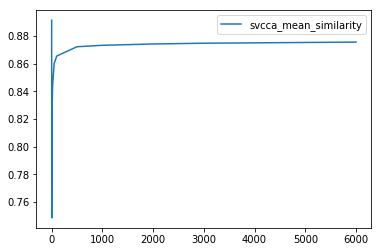

In [7]:
# Plot
svcca_raw_df.plot()

In [8]:
# Check datasets batch 1 and original are the same
batch_1_file = os.path.join(
    batch_dir,
    "Batch_1.txt")
print(batch_1_file)

batch_1 = pd.read_table(
    batch_1_file,
    header=0,
    sep='\t',
    index_col=0)
    
batch_1.head(10)

/home/alexandra/Documents/Repos/Batch_effects_simulation/data/batch_simulated/experiment_0/Batch_1.txt


,0,1,2,3,4,5,6,7,8,9,...,5539,5540,5541,5542,5543,5544,5545,5546,5547,5548
0,0.690384,0.642501,0.454786,0.650650,0.374857,0.414020,0.353704,0.566726,0.447497,0.165201,...,0.375559,0.600063,0.562897,0.640035,0.661894,0.325466,0.576836,0.567330,0.708088,0.615353
1,0.691060,0.655274,0.527149,0.680636,0.371842,0.443242,0.374220,0.533293,0.502785,0.165815,...,0.290522,0.591411,0.609883,0.585498,0.596831,0.162511,0.459705,0.531669,0.710235,0.698571
2,0.826005,0.694632,0.510346,0.642764,0.611429,0.517733,0.344205,0.631357,0.663116,0.199852,...,0.589395,0.581802,0.596350,0.671666,0.753091,0.160510,0.521740,0.511157,0.747738,0.728167
3,0.600721,0.564944,0.417176,0.594936,0.382868,0.440063,0.387031,0.466111,0.402363,0.223858,...,0.345520,0.547836,0.470917,0.460431,0.564647,0.256127,0.509963,0.348220,0.579351,0.583487
4,0.621544,0.615939,0.473489,0.599652,0.401605,0.481008,0.364476,0.444714,0.447605,0.215759,...,0.450535,0.532127,0.588728,0.547413,0.578212,0.234255,0.424777,0.501985,0.704726,0.717408
5,0.735929,0.732768,0.545550,0.632979,0.460602,0.437013,0.325476,0.572898,0.682289,0.203184,...,0.414369,0.576000,0.692773,0.643043,0.746655,0.215016,0.509911,0.638528,0.775373,0.746010
6,0.643262,0.647871,0.449706,0.552101,0.407846,0.421758,0.371682,0.551611,0.530684,0.185147,...,0.392800,0.503936,0.558234,0.505509,0.600357,0.213806,0.478426,0.443200,0.641380,0.686138
7,0.517200,0.567826,0.363922,0.483920,0.346046,0.440530,0.442479,0.474701,0.372429,0.156235,...,0.368144,0.488229,0.461496,0.446372,0.480050,0.364032,0.477898,0.388174,0.528046,0.492165
8,0.746649,0.745975,0.622174,0.748726,0.455695,0.499827,0.260720,0.625723,0.640932,0.206239,...,0.421102,0.636195,0.681262,0.676396,0.637278,0.241293,0.594934,0.663525,0.725401,0.708356
9,0.580710,0.586180,0.419463,0.592984,0.368153,0.405530,0.403313,0.445573,0.449738,0.212873,...,0.419540,0.534721,0.509361,0.491707,0.524512,0.257988,0.408664,0.429760,0.594038,0.572804


In [9]:
i = 1
batch_other_file = os.path.join(
    batch_dir,
    "Batch_"+str(i)+".txt")
print(batch_other_file)

batch_other = pd.read_table(
    batch_other_file,
    header=0,
    sep='\t',
    index_col=0)

batch_other.head(10)

/home/alexandra/Documents/Repos/Batch_effects_simulation/data/batch_simulated/experiment_0/Batch_1.txt


,0,1,2,3,4,5,6,7,8,9,...,5539,5540,5541,5542,5543,5544,5545,5546,5547,5548
0,0.690384,0.642501,0.454786,0.650650,0.374857,0.414020,0.353704,0.566726,0.447497,0.165201,...,0.375559,0.600063,0.562897,0.640035,0.661894,0.325466,0.576836,0.567330,0.708088,0.615353
1,0.691060,0.655274,0.527149,0.680636,0.371842,0.443242,0.374220,0.533293,0.502785,0.165815,...,0.290522,0.591411,0.609883,0.585498,0.596831,0.162511,0.459705,0.531669,0.710235,0.698571
2,0.826005,0.694632,0.510346,0.642764,0.611429,0.517733,0.344205,0.631357,0.663116,0.199852,...,0.589395,0.581802,0.596350,0.671666,0.753091,0.160510,0.521740,0.511157,0.747738,0.728167
3,0.600721,0.564944,0.417176,0.594936,0.382868,0.440063,0.387031,0.466111,0.402363,0.223858,...,0.345520,0.547836,0.470917,0.460431,0.564647,0.256127,0.509963,0.348220,0.579351,0.583487
4,0.621544,0.615939,0.473489,0.599652,0.401605,0.481008,0.364476,0.444714,0.447605,0.215759,...,0.450535,0.532127,0.588728,0.547413,0.578212,0.234255,0.424777,0.501985,0.704726,0.717408
5,0.735929,0.732768,0.545550,0.632979,0.460602,0.437013,0.325476,0.572898,0.682289,0.203184,...,0.414369,0.576000,0.692773,0.643043,0.746655,0.215016,0.509911,0.638528,0.775373,0.746010
6,0.643262,0.647871,0.449706,0.552101,0.407846,0.421758,0.371682,0.551611,0.530684,0.185147,...,0.392800,0.503936,0.558234,0.505509,0.600357,0.213806,0.478426,0.443200,0.641380,0.686138
7,0.517200,0.567826,0.363922,0.483920,0.346046,0.440530,0.442479,0.474701,0.372429,0.156235,...,0.368144,0.488229,0.461496,0.446372,0.480050,0.364032,0.477898,0.388174,0.528046,0.492165
8,0.746649,0.745975,0.622174,0.748726,0.455695,0.499827,0.260720,0.625723,0.640932,0.206239,...,0.421102,0.636195,0.681262,0.676396,0.637278,0.241293,0.594934,0.663525,0.725401,0.708356
9,0.580710,0.586180,0.419463,0.592984,0.368153,0.405530,0.403313,0.445573,0.449738,0.212873,...,0.419540,0.534721,0.509361,0.491707,0.524512,0.257988,0.408664,0.429760,0.594038,0.572804


In [10]:
# Verify that batch 1 vs itself is 100% similar
svcca_results_batch1_itself = cca_core.get_cca_similarity(batch_1.T,
                                          batch_1.T,
                                          verbose=False)
np.mean(svcca_results_batch1_itself["cca_coef1"])

0.8914584592316003

In [11]:
# Verify that batch 1 vs itself is 100% similar
svcca_results_batch1_other = cca_core.get_cca_similarity(batch_1.T,
                                          batch_other.T,
                                          verbose=False)
np.mean(svcca_results_batch1_other["cca_coef1"])

0.8914584592316003

In [24]:
# Calculate Similarity using PCA projection of batched data

output_list = []

for i in num_batches:
    print('Calculating SVCCA score for 1 batch vs {} batches..'.format(i))
    
    # Get batch 1
    batch_1_file = os.path.join(
        batch_dir,
        "Batch_1.txt")

    batch_1 = pd.read_table(
        batch_1_file,
        header=0,
        sep='\t',
        index_col=0)

    # PCA projection
    pca = PCA(n_components=1000)

    # Use trained model to encode expression data into SAME latent space
    original_data_PCAencoded = pca.fit_transform(batch_1)


    original_data_PCAencoded_df = pd.DataFrame(original_data_PCAencoded,
                                         index=batch_1.index
                                         )
    
    # All batches
    batch_other_file = os.path.join(
        batch_dir,
        "Batch_"+str(i)+".txt")

    batch_other = pd.read_table(
        batch_other_file,
        header=0,
        sep='\t',
        index_col=0)
    
    print("Using batch {}".format(i))
    
    # Use trained model to encode expression data into SAME latent space
    batch_data_PCAencoded = pca.fit_transform(batch_other)
    
    
    batch_data_PCAencoded_df = pd.DataFrame(batch_data_PCAencoded,
                                         index=batch_other.index
                                         )
        
    # Check shape
    if original_data_PCAencoded_df.shape[0] != batch_data_PCAencoded_df.shape[0]:
        diff = original_data_PCAencoded_df.shape[0] - batch_data_PCAencoded_df.shape[0]
        original_data_PCAencoded_df = original_data_PCAencoded_df.iloc[:-diff,:]
    
    # SVCCA
    svcca_results = cca_core.get_cca_similarity(original_data_PCAencoded_df.T,
                                          batch_data_PCAencoded_df.T,
                                          verbose=False)
    
    output_list.append(np.mean(svcca_results["cca_coef1"]))

# Convert output to pandas dataframe
svcca_pca_df = pd.DataFrame(output_list, columns=["svcca_mean_similarity"], index=num_batches)
svcca_pca_df

Calculating SVCCA score for 1 batch vs 1 batches..
Using batch 1
Calculating SVCCA score for 1 batch vs 2 batches..
Using batch 2
Calculating SVCCA score for 1 batch vs 5 batches..
Using batch 5
Calculating SVCCA score for 1 batch vs 10 batches..
Using batch 10
Calculating SVCCA score for 1 batch vs 20 batches..
Using batch 20
Calculating SVCCA score for 1 batch vs 50 batches..
Using batch 50
Calculating SVCCA score for 1 batch vs 100 batches..
Using batch 100
Calculating SVCCA score for 1 batch vs 500 batches..
Using batch 500
Calculating SVCCA score for 1 batch vs 1000 batches..
Using batch 1000
Calculating SVCCA score for 1 batch vs 2000 batches..
Using batch 2000
Calculating SVCCA score for 1 batch vs 3000 batches..
Using batch 3000
Calculating SVCCA score for 1 batch vs 6000 batches..
Using batch 6000


,svcca_mean_similarity
1,0.935091
2,0.191038
5,0.324309
10,0.340191
20,0.343503
50,0.346443
100,0.346655
500,0.346389
1000,0.347476
2000,0.347351


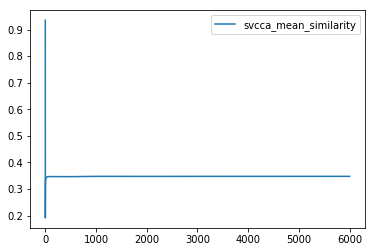

In [25]:
# Plot
svcca_pca_df.plot()

In [18]:
# Manually compute similarity by applying CCA to PCs
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=1)

output_list = []

for i in num_batches:
    print('Calculating SVCCA score for 1 batch vs {} batches..'.format(i))
    
    # Get batch 1
    batch_1_file = os.path.join(
        batch_dir,
        "Batch_1.txt")

    batch_1 = pd.read_table(
        batch_1_file,
        header=0,
        sep='\t',
        index_col=0)

    # PCA projection
    pca = PCA(n_components=1000)

    # Use trained model to encode expression data into SAME latent space
    original_data_PCAencoded = pca.fit_transform(batch_1)


    original_data_PCAencoded_df = pd.DataFrame(original_data_PCAencoded,
                                         index=batch_1.index
                                         )
    
    # All batches
    batch_other_file = os.path.join(
        batch_dir,
        "Batch_"+str(i)+".txt")

    batch_other = pd.read_table(
        batch_other_file,
        header=0,
        sep='\t',
        index_col=0)
    
    print("Using batch {}".format(i))
    
    # Use trained model to encode expression data into SAME latent space
    batch_data_PCAencoded = pca.fit_transform(batch_other)
    
    
    batch_data_PCAencoded_df = pd.DataFrame(batch_data_PCAencoded,
                                         index=batch_other.index
                                         )
        
    # Check shape
    if original_data_PCAencoded_df.shape[0] != batch_data_PCAencoded_df.shape[0]:
        diff = original_data_PCAencoded_df.shape[0] - batch_data_PCAencoded_df.shape[0]
        original_data_PCAencoded_df = original_data_PCAencoded_df.iloc[:-diff,:]
    
    # CCA
    U_c, V_c = cca.fit_transform(original_data_PCAencoded_df, batch_data_PCAencoded_df)
    result = np.corrcoef(U_c.T, V_c.T)[0,1]
    
    output_list.append(result)

# Convert output to pandas dataframe
pca_cca_df = pd.DataFrame(output_list, columns=["svcca_mean_similarity"], index=num_batches)
pca_cca_df

Calculating SVCCA score for 1 batch vs 1 batches..
Using batch 1
Calculating SVCCA score for 1 batch vs 2 batches..
Using batch 2
Calculating SVCCA score for 1 batch vs 5 batches..
Using batch 5
Calculating SVCCA score for 1 batch vs 10 batches..
Using batch 10
Calculating SVCCA score for 1 batch vs 20 batches..
Using batch 20
Calculating SVCCA score for 1 batch vs 50 batches..
Using batch 50
Calculating SVCCA score for 1 batch vs 100 batches..
Using batch 100


/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:77: UserWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached')


Calculating SVCCA score for 1 batch vs 500 batches..
Using batch 500
Calculating SVCCA score for 1 batch vs 1000 batches..
Using batch 1000
Calculating SVCCA score for 1 batch vs 2000 batches..
Using batch 2000
Calculating SVCCA score for 1 batch vs 3000 batches..
Using batch 3000
Calculating SVCCA score for 1 batch vs 6000 batches..
Using batch 6000


,svcca_mean_similarity
1,1.000000
2,0.745088
5,0.748896
10,0.748394
20,0.745215
50,0.773709
100,0.746073
500,0.747002
1000,0.742975
2000,0.745541


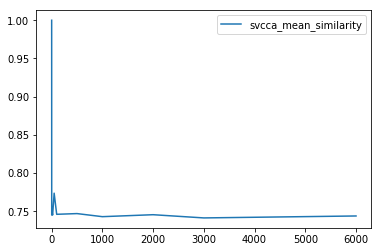

In [19]:
# Plot
pca_cca_df.plot()

In [ ]:
# svcca of original vs original 
# Is there an issue with the VAE generated simulated data?